In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [2]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

fatal: destination path 'arabert' already exists and is not an empty directory.


#Creating training datasets

In [3]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

This custom dataset class will help us hold our datasets in a structred manner.
It's not necessary to use it with your own data

In [4]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [5]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

##Dataset

In [6]:
#read my dataset
res_df=pd.read_csv('https://raw.githubusercontent.com/hadyelsahar/large-arabic-sentiment-analysis-resouces/master/datasets/RES.csv')
prod_df=pd.read_csv('https://raw.githubusercontent.com/hadyelsahar/large-arabic-sentiment-analysis-resouces/master/datasets/PROD.csv')
htl_df=pd.read_csv('https://raw.githubusercontent.com/hadyelsahar/large-arabic-sentiment-analysis-resouces/master/datasets/HTL.csv')
mov_df=pd.read_csv('https://raw.githubusercontent.com/hadyelsahar/large-arabic-sentiment-analysis-resouces/master/datasets/MOV.csv')

#I need pos and neg only
res_df=res_df[res_df['polarity']!=0].reset_index(drop=True)
prod_df=prod_df[prod_df['polarity']!=0].reset_index(drop=True)
htl_df=htl_df[htl_df['polarity']!=0].reset_index(drop=True)
mov_df=mov_df[mov_df['polarity']!=0].reset_index(drop=True)


datasetDict = {"resturants": res_df, "products": prod_df, "hotels": htl_df, "movies": mov_df}
all_msa = pd.concat([res_df, prod_df, htl_df, mov_df])
hard_map = {
    1: 'POS',
   -1: 'NEG'
}

for k, d in datasetDict.items():
  d.columns = [DATA_COLUMN, LABEL_COLUMN]
  d[LABEL_COLUMN] = d[LABEL_COLUMN].apply(lambda x: hard_map[x])
  label_list_d = ['NEG', 'POS']
  train_d, test_d = train_test_split(d, test_size=0.2, random_state=42)
  data_d = CustomDataset(k, train_d, test_d, label_list_d)
  all_datasets.append(data_d)

# add combined 

all_msa.columns = [DATA_COLUMN, LABEL_COLUMN]
all_msa[LABEL_COLUMN] = all_msa[LABEL_COLUMN].apply(lambda x: hard_map[x])
label_list_all = ['NEG', 'POS']
train_all, test_all = train_test_split(all_msa, test_size=0.2, random_state=42)
data_all = CustomDataset("All_MSA", train_all, test_all, label_list_all)
all_datasets.append(data_all)

In [7]:
#read files of second dataset 
cor_df=pd.read_csv('ArSenTD-LEV.tsv', sep='\t')
cor_df= cor_df.drop(columns=['Country', 'Sentiment_Expression','Sentiment_Target','Topic'])
cor_df= cor_df.drop(columns=[])
#keep only binary classes (pos & neg)
cor_df=cor_df[cor_df['Sentiment']!='neutral'].reset_index(drop=True)
#unify format with other dataset
cor_df['Sentiment'].replace({'very_positive': '1', 'positive': '1', 'very_negative':'0', 'negative':'0'}, inplace=True)
cor_df= cor_df.reset_index(drop=True)
cor_df.rename(columns={'Tweet': 'text', 'Sentiment': 'polarity'}, inplace=True)
cor_df["polarity"] = pd.to_numeric(cor_df["polarity"])
cor_df

,text,polarity
0,"""أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد م...",0
1,من الذاكره... @3FInQe . عندما اعتقد كريستيانو ...,1
2,#مصطلحات_لبنانيه_حيرت_البشريه بتوصل عالبيت ، ب...,0
3,نصمت !! لتسير حياتنا على مً يرام فالناّس لم تع...,0
4,@Yousef_MUFC اكثر ما يزعجنا بعد مستوانا خارج ا...,0
...,...,...
3110,نهتم من خلال خدمة تنسيق الرسائل بإظهار رسالة ا...,1
3111,صلاح من لاعب في المقاولون العرب يحلم ان يلعب ل...,1
3112,الملك سلمان بن عبد العزيز: تطبيق الأنظمة بحزم ...,1
3113,@ZahraaIraq9 😂 كل ما ادخل حسابي الكه تغريداتج ...,0


In [8]:
import re
import string
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [9]:
cor_df['text'] = cor_df['text'].apply(remove_emoji)

In [10]:
cor_df

,text,polarity
0,"""أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد م...",0
1,من الذاكره... @3FInQe . عندما اعتقد كريستيانو ...,1
2,#مصطلحات_لبنانيه_حيرت_البشريه بتوصل عالبيت ، ب...,0
3,نصمت !! لتسير حياتنا على مً يرام فالناّس لم تع...,0
4,@Yousef_MUFC اكثر ما يزعجنا بعد مستوانا خارج ا...,0
...,...,...
3110,نهتم من خلال خدمة تنسيق الرسائل بإظهار رسالة ا...,1
3111,صلاح من لاعب في المقاولون العرب يحلم ان يلعب ل...,1
3112,الملك سلمان بن عبد العزيز: تطبيق الأنظمة بحزم ...,1
3113,@ZahraaIraq9 كل ما ادخل حسابي الكه تغريداتج ع...,0


In [11]:
hard_map = {
    1: 'POS',
    0: 'NEG'
}
cor_df.columns = [DATA_COLUMN, LABEL_COLUMN]
cor_df[LABEL_COLUMN] = cor_df[LABEL_COLUMN].apply(lambda x: hard_map[x])
label_list_d = ['NEG', 'POS']
train_d, test_d = train_test_split(cor_df, test_size=0.2, random_state=42)
data_d = CustomDataset('ArSenTD-Lev', train_d, test_d, label_list_d)
all_datasets.append(data_d)

#Trainer

Start the training procedure

In [12]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

List all the datasets we have

In [13]:
for x in all_datasets:
  print(x.name)

resturants
products
hotels
movies
All_MSA
ArSenTD-Lev


In [14]:
# select a dataset
dataset_name = 'All_MSA'
# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
model_name = 'aubmindlab/bert-base-arabertv02' # this model doesn't require preprocess/pre-segmentation

In [15]:
import copy
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = copy.deepcopy(d)
    print('Dataset found')
    break

Dataset found


In [ ]:
############# RES
selected_dataset.train

,text,label
2312,مطعم لبناني \nالمطعم ديكور ممتاز و الاكل وسط ف...,NEG
2516,أفوكادوا مطعم للوجبات السريعة و يقدم تشكيلة من...,POS
3467,الوجبات جداً لذيذة ، والمنيو متنوع بالأطباق وا...,POS
8552,مستواه اعطيه من عشره ١٠/٤ سيء جدا,NEG
10213,لي قصص طويلة مع هذه البوفية من أيام المرحلة ال...,POS
...,...,...
5734,أسوء مطعم دخلته في حياتي نظافه ٢/١٠ الأكل ٠...,NEG
5191,مطعم جداً سيئ ورديئ واكل غير لذيذ ولا تفرق ب...,NEG
5390,ذهبت البارحة الى فرع الثلاثين بالرياض لتجربة ا...,POS
860,الجبيل \nبصراحة انا ما اكلت اكلات ايطاليه مثل ...,POS


In [ ]:
############## PROD
selected_dataset.train

,text,label
1344,حلوة مما تجعل استخدامها في عده اجهزة كما يسهل ...,POS
3353,Good and easy to apply,POS
1117,السعر نااااار,NEG
3824,رائع و انصح بيه للشباب لتمارين الاطاله و العقله,NEG
2805,جميل في الامكانيات والشكل,POS
...,...,...
1130,جدا ممتازه من حيث الشكل والاستخدام والاداء فهو...,POS
1294,ارغب في المزيد من حافظات لهذا الجوال لانه لم ا...,POS
860,صغيرة جدا ولا تأخذ مساحة في الحقيبه. سهلة الطي...,POS
3507,الاطباق جميلة جدا وخامتها ممتازة والمنتج زي ال...,POS


In [ ]:
############## Hotels
selected_dataset.train

,text,label
3477,السعاده مع الله \r\nالحمدلله كل المرافق في هذا...,POS
8005,أحببته- أفضل بكثير مما توقعت! \r\nمكثنا هنا لل...,POS
5747,اختيار جيد في هانوي \r\nفندق ممتاز للإقامة في...,POS
7897,مكان مريح وذو جودة عالية للإقامة في الواحات ال...,POS
11029,من اروع ما راينا في المدلينا!!مذهل \r\nاستقبال...,POS
...,...,...
5191,ملاحظات عن السكن \r\nكانت إقامتي جيدة جداً، ف...,POS
13418,قريب من كل شي \r\nجميل وهادي وكل شي حولك حتي ا...,POS
5390,رائع في إنسبروك الخلابة \r\nمن موقع مثالي مع ...,POS
860,موقع ممتاز وفريق موظفين ودود \r\nلم يكن فريق ا...,POS


In [ ]:
############## movies
selected_dataset.train

,text,label
966,اتفرج ومدققش عشان تعرف تستمتع في أفلام بالرغم ...,NEG
932,شكل تاني لهيتشكوك عرفت المخرج هيتشكوك وعشقت فن...,POS
109,عفوا ايها القانون وصرخة احتجاج اعتادت المخرجة ...,POS
714,فيلم الكايجو كما يجب أن يكون Kaiju .. كلمة ياب...,POS
1200,"الطفلة جني أنقذت ""سامي أكسيد الكربون"" من الملل...",NEG
...,...,...
1095,ادبح يا زكي قدرة ...يدبح زكي قدرة حتما عندما ي...,POS
1130,سينما الاستفزاز بعد مشاهدة الجزء الثالث من سلس...,NEG
1294,"خطاب الملك لاوين ميرخان محمد الاقتباس """"في بدء...",POS
860,فيلم جميل ولكن فيلم الوتر جميل ومثير للاهتمام ...,NEG


In [16]:
############# All msa
selected_dataset.train

,text,label
6072,قد اكلت من هالمطعم مرتين وكلها الحمدلله تجارب ...,POS
8216,فندق روعة التصميم والموقع \r\nالخدمات ممتازة و...,POS
74,اوضتين لبيبو وبشير و حشو ملهوش تأثير يبدو أن م...,NEG
1358,كانت تجربة جميلة \r\nقضينا في هذا الفندق ليلة ...,POS
7046,تايم شير بالعافية أو بالإحراج \r\nعندما تذهب إ...,NEG
...,...,...
6906,فندق متميز \r\nفندق متميز في كل شئ ، العاملين ...,POS
5390,ذهبت البارحة الى فرع الثلاثين بالرياض لتجربة ا...,POS
860,الجبيل \nبصراحة انا ما اكلت اكلات ايطاليه مثل ...,POS
1126,"فندق جيد وغرفه رحبه \r\n""لديهم غرف كبيرة جداً ...",POS


In [ ]:
########### ArSenTD-Lev
selected_dataset.train

,text,label
521,إن قدرتنا على تحكيم أدوات البحث العلمي في مختل...,POS
522,@Huda9499 كلامك صحيح . لكن الحب موجود بغض النظ...,POS
1641,تأخر تشكيل حكومة جديدة لا شي سوى لتكون مناسبة ...,NEG
2057,@alaajameel225 @HaiderAlAbadi حبيبي تعال لليرم...,NEG
1010,نحن نعيش أَوج عصر التفاهة . حيث عقد الزواج أهم...,NEG
...,...,...
3092,نأمل من كل من يترشح بالانتخابات اللبنانية المق...,NEG
1095,أهلاً بك صديقي الأستاذ سليمان السميري ... هذا ...,POS
1130,حدث في مثل هذا اليوم قبل سنة. تحرير مركز ناحية...,POS
1294,تم قبول الشيخ / #ناصر_ بن_عبدالله_ ابن_ زيد ، ...,POS


Create and apply preprocessing using the AraBERT processor

In [17]:
arabic_prep = ArabertPreprocessor(model_name)

selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))  

In [ ]:
selected_dataset.train

,text,label
3477,السعاده مع الله الحمدلله كل المرافق في هذا الف...,POS
8005,أحببته - أفضل بكثير مما توقعت ! مكثنا هنا لليل...,POS
5747,"اختيار جيد في هانوي فندق ممتاز للإقامة في "" ها...",POS
7897,مكان مريح وذو جودة عالية للإقامة في الواحات ال...,POS
11029,من اروع ما راينا في المدلينا ! ! مذهل استقبال ...,POS
...,...,...
5191,ملاحظات عن السكن كانت إقامتي جيدة جدا ، في غرف...,POS
13418,قريب من كل شي جميل وهادي وكل شي حولك حتي الموا...,POS
5390,رائع في إنسبروك الخلابة من موقع مثالي مع إطلال...,POS
860,موقع ممتاز وفريق موظفين ودود لم يكن فريق الموظ...,POS


In [ ]:
# Sanity check on the dataset
list(selected_dataset.train[DATA_COLUMN][0:10])

['السعاده مع الله الحمدلله كل المرافق في هذا الفندق كانت ممتازه وجميلا ورائعة والحمدلله وإنني اتمني لكم التوفيق واتنمي النجاح وادعو الله القدير ان يحفظ هذا البلد وأمر ائه والقائمين علي بيت الله الحرام كل الخير والسعادة .',
 'أحببته - أفضل بكثير مما توقعت ! مكثنا هنا لليلة واحدة من قبل حيث أنه كان نقطة التجمع في رحلتنا . وبعد قراءة الكثير من التعليقات السلبية ، قررنا أن تقيم في مكان آخر بعد رحلتنا . ويا لها من غلطة ارتكبناها بعدم البقاء هنا طوال الوقت ! هذا الفندق لديه نقاط رائعة وكذلك بعض النقاط السيئة . الغرفة الأولى التي حصلنا عليها كانت كبيرة ، والتكييف جيد والحمام مذهل ! ولكن في اليوم الثاني قررت المياه عدم الخروج من الصنابير الأمر الذي كان محبطا . الليلة الأخيرة في رحلتنا تضمنت المبيت هنا وقاموا بترقية حجزنا إلى غرفة مزدوجة مذهلة . كانت ضخمة ! غرفة نوم كبيرة ، حمام ، غرفة منفصلة فيها مقاعد وطاولات للجلوس حولها وشرفة . مكيف الهواء لم يعمل ولكن بعد إعلامهم بالأمر عملوا على إصلاحه . ومع أنني لم أشعر بالأمان 100 % إذا ما ذهبت للمشي في الليل لوحدي ، إلا أن الوضع لم يكن سيئا جدا ، خاصة 

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [18]:
tok = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Training Sentence Lengths: 


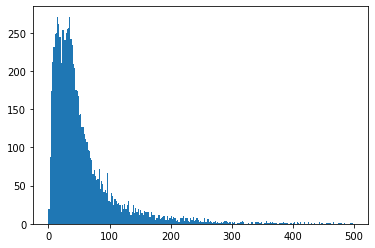

Testing Sentence Lengths: 


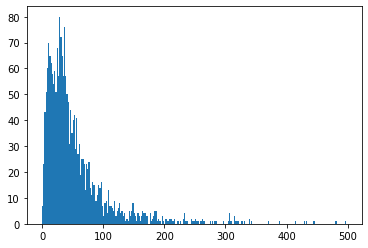

In [ ]:
#################### resturants
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (771 > 512). Running this sequence through the model will result in indexing errors


Training Sentence Lengths: 


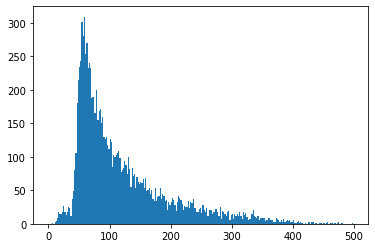

Testing Sentence Lengths: 


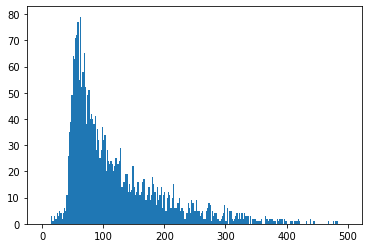

In [ ]:
#################### Hotels
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

Training Sentence Lengths: 


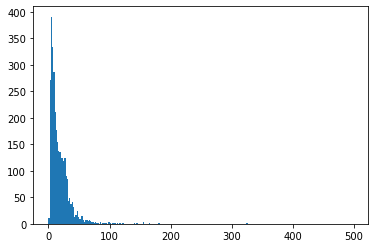

Testing Sentence Lengths: 


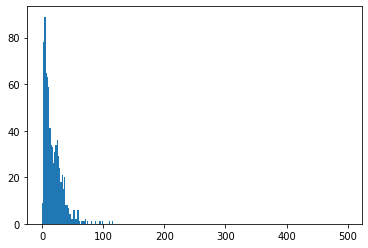

In [ ]:
#################### products
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

Training Sentence Lengths: 


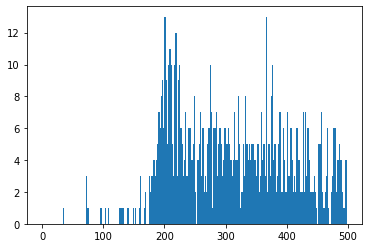

Testing Sentence Lengths: 


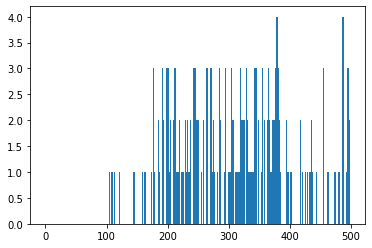

In [ ]:
#################### movies
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (874 > 512). Running this sequence through the model will result in indexing errors


Training Sentence Lengths: 


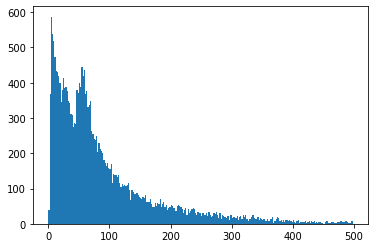

Testing Sentence Lengths: 


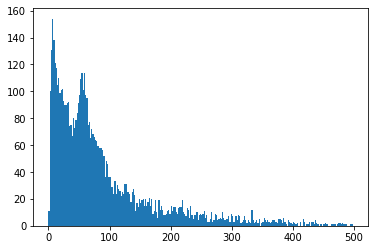

In [19]:
#################### All msa
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

Training Sentence Lengths: 


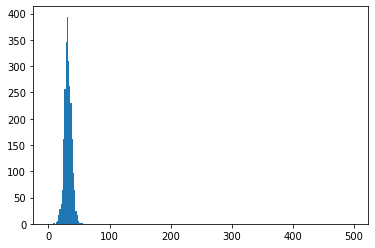

Testing Sentence Lengths: 


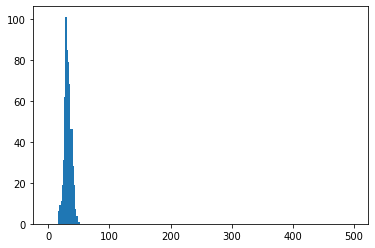

In [ ]:
#################### ArSenTD-Lev
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,500,2))
plt.show()

Let's select our maximum sentence length, and check how many sequences will be truncated

In [20]:
max_len = 128 # for MSA 

In [ ]:
max_len = 50 # for tweets: ArSenTD-Lev

In [ ]:
######################## resturant
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.train[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.train))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.test))

Truncated training sequences:  731  out of : 8564
Truncated testing sequences:  176  out of : 2141


In [ ]:
######################## products
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.train[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.train))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.test))

Truncated training sequences:  9  out of : 3171
Truncated testing sequences:  0  out of : 793


In [ ]:
######################## hotels
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.train[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.train))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.test))

Truncated training sequences:  3524  out of : 10737
Truncated testing sequences:  891  out of : 2685


In [ ]:
######################## movies
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.train[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.train))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.test))

Truncated training sequences:  1072  out of : 1082
Truncated testing sequences:  267  out of : 271


In [21]:
######################## All msa
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.train[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.train))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.test))

Truncated training sequences:  5341  out of : 23555
Truncated testing sequences:  1329  out of : 5889


In [ ]:
######################## ArSenTD-Lev
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.train[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.train))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]), ' out of :', len(selected_dataset.test))

Truncated training sequences:  5  out of : 2492
Truncated testing sequences:  0  out of : 623


Now let's create a classification dataset to load the data

In [22]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
      

    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
        
      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )      
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [23]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    selected_dataset.train[DATA_COLUMN].to_list(),
    selected_dataset.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    selected_dataset.test[DATA_COLUMN].to_list(),
    selected_dataset.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'NEG': 0, 'POS': 1}


Check the dataset output

In [24]:
print(next(iter(train_dataset)))     # printed with length 128

InputFeatures(input_ids=[2, 602, 49262, 228, 306, 19120, 27433, 482, 8190, 22463, 6620, 45541, 7936, 25074, 195, 22, 19, 7596, 183, 12786, 57, 243, 251, 7596, 183, 12786, 1848, 56111, 482, 3236, 5138, 38609, 201, 209, 1305, 16637, 1241, 14, 2339, 47587, 29682, 1841, 14788, 195, 1882, 1130, 15, 103, 354, 3080, 2077, 9632, 22251, 182, 1955, 2766, 30533, 6399, 867, 401, 963, 394, 1245, 52634, 674, 23, 19, 3699, 50181, 533, 408, 6983, 390, 20912, 391, 34119, 593, 870, 3626, 1016, 5138, 38609, 201, 209, 1305, 16637, 1241, 2285, 2134, 18322, 969, 195, 611, 6583, 238, 1841, 47587, 8142, 662, 1016, 867, 20040, 4683, 1918, 193, 40499, 182, 7596, 183, 37216, 391, 34119, 21442, 1841, 29682, 25534, 305, 7700, 49571, 14144, 7375, 20040, 49594, 195, 45657, 2885, 5153, 3], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
print(next(iter(train_dataset)))     # printed with length 50 (ArSenTD-Lev)

InputFeatures(input_ids=[2, 476, 42975, 323, 15195, 10054, 2336, 4268, 305, 1259, 11081, 46803, 750, 6511, 306, 36911, 307, 38207, 4193, 5737, 323, 2868, 8357, 881, 176, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], label=1)


Create a function that return a pretrained model ready to do classification

In [25]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [26]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  print(confusion_matrix(p.label_ids,preds))
  score_F1 = f1_score(p.label_ids,preds)
  score_precision = precision_score(p.label_ids,preds)
  score_recall = recall_score(p.label_ids,preds)
  acc = accuracy_score(p.label_ids,preds)
  return {       
      'F1_score' : score_F1,
      'Accuracy': acc,
      'Precision': score_precision,
      'Recall': score_recall
  }

In [27]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

**Training** 

Define our training parameters.

In [28]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 5, 
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'F1_score',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

Create the trainer

In [29]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

**Results of training on each dataset**

In [ ]:
############# resturants




#start the training on resturants
trainer.train()

***** Running training *****
  Num examples = 8564
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1340


Epoch,Training Loss,Validation Loss,F1 Score,Accuracy,Precision,Recall
1,No log,0.230978,0.940631,0.910322,0.934275,0.947073
2,0.249000,0.226914,0.944597,0.915460,0.928958,0.960772
3,0.249000,0.263643,0.943951,0.914526,0.928873,0.959527
4,0.114600,0.332139,0.940667,0.910322,0.933742,0.947696
5,0.114600,0.363492,0.940812,0.910789,0.936459,0.945205


***** Running Evaluation *****
  Num examples = 2141
  Batch size = 128


              precision    recall  f1-score   support

           0       0.83      0.80      0.82       535
           1       0.93      0.95      0.94      1606

    accuracy                           0.91      2141
   macro avg       0.88      0.87      0.88      2141
weighted avg       0.91      0.91      0.91      2141

[[ 428  107]
 [  85 1521]]


Saving model checkpoint to ./train/checkpoint-268
Configuration saved in ./train/checkpoint-268/config.json
Model weights saved in ./train/checkpoint-268/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2141
  Batch size = 128


              precision    recall  f1-score   support

           0       0.87      0.78      0.82       535
           1       0.93      0.96      0.94      1606

    accuracy                           0.92      2141
   macro avg       0.90      0.87      0.88      2141
weighted avg       0.91      0.92      0.91      2141

[[ 417  118]
 [  63 1543]]


Saving model checkpoint to ./train/checkpoint-536
Configuration saved in ./train/checkpoint-536/config.json
Model weights saved in ./train/checkpoint-536/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2141
  Batch size = 128


              precision    recall  f1-score   support

           0       0.87      0.78      0.82       535
           1       0.93      0.96      0.94      1606

    accuracy                           0.91      2141
   macro avg       0.90      0.87      0.88      2141
weighted avg       0.91      0.91      0.91      2141

[[ 417  118]
 [  65 1541]]


Saving model checkpoint to ./train/checkpoint-804
Configuration saved in ./train/checkpoint-804/config.json
Model weights saved in ./train/checkpoint-804/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2141
  Batch size = 128


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       535
           1       0.93      0.95      0.94      1606

    accuracy                           0.91      2141
   macro avg       0.88      0.87      0.88      2141
weighted avg       0.91      0.91      0.91      2141

[[ 427  108]
 [  84 1522]]


Saving model checkpoint to ./train/checkpoint-1072
Configuration saved in ./train/checkpoint-1072/config.json
Model weights saved in ./train/checkpoint-1072/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2141
  Batch size = 128


              precision    recall  f1-score   support

           0       0.83      0.81      0.82       535
           1       0.94      0.95      0.94      1606

    accuracy                           0.91      2141
   macro avg       0.88      0.88      0.88      2141
weighted avg       0.91      0.91      0.91      2141

[[ 432  103]
 [  88 1518]]


Saving model checkpoint to ./train/checkpoint-1340
Configuration saved in ./train/checkpoint-1340/config.json
Model weights saved in ./train/checkpoint-1340/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-536 (score: 0.9445974900520354).


TrainOutput(global_step=1340, training_loss=0.1515536877646375, metrics={'train_runtime': 5238.7336, 'train_samples_per_second': 8.174, 'train_steps_per_second': 0.256, 'total_flos': 2816603847628800.0, 'train_loss': 0.1515536877646375, 'epoch': 5.0})

In [ ]:
############# products




#start the training on resturants
trainer.train()

***** Running training *****
  Num examples = 3171
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 495


Epoch,Training Loss,Validation Loss,F1 Score,Accuracy,Precision,Recall
0,No log,0.286235,0.942368,0.906683,0.922256,0.963376
1,No log,0.277628,0.939347,0.901639,0.917933,0.961783
2,No log,0.296685,0.933547,0.895334,0.938808,0.928344
3,No log,0.319459,0.935433,0.896595,0.925234,0.945860
4,No log,0.328508,0.935867,0.897856,0.930709,0.941083


***** Running Evaluation *****
  Num examples = 793
  Batch size = 128


              precision    recall  f1-score   support

           0       0.83      0.69      0.75       165
           1       0.92      0.96      0.94       628

    accuracy                           0.91       793
   macro avg       0.88      0.83      0.85       793
weighted avg       0.90      0.91      0.90       793

[[114  51]
 [ 23 605]]


Saving model checkpoint to ./train/checkpoint-99
Configuration saved in ./train/checkpoint-99/config.json
Model weights saved in ./train/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 793
  Batch size = 128


              precision    recall  f1-score   support

           0       0.82      0.67      0.74       165
           1       0.92      0.96      0.94       628

    accuracy                           0.90       793
   macro avg       0.87      0.82      0.84       793
weighted avg       0.90      0.90      0.90       793

[[111  54]
 [ 24 604]]


Saving model checkpoint to ./train/checkpoint-198
Configuration saved in ./train/checkpoint-198/config.json
Model weights saved in ./train/checkpoint-198/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 793
  Batch size = 128


              precision    recall  f1-score   support

           0       0.74      0.77      0.75       165
           1       0.94      0.93      0.93       628

    accuracy                           0.90       793
   macro avg       0.84      0.85      0.84       793
weighted avg       0.90      0.90      0.90       793

[[127  38]
 [ 45 583]]


Saving model checkpoint to ./train/checkpoint-297
Configuration saved in ./train/checkpoint-297/config.json
Model weights saved in ./train/checkpoint-297/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 793
  Batch size = 128


              precision    recall  f1-score   support

           0       0.77      0.71      0.74       165
           1       0.93      0.95      0.94       628

    accuracy                           0.90       793
   macro avg       0.85      0.83      0.84       793
weighted avg       0.89      0.90      0.89       793

[[117  48]
 [ 34 594]]


Saving model checkpoint to ./train/checkpoint-396
Configuration saved in ./train/checkpoint-396/config.json
Model weights saved in ./train/checkpoint-396/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 793
  Batch size = 128


              precision    recall  f1-score   support

           0       0.77      0.73      0.75       165
           1       0.93      0.94      0.94       628

    accuracy                           0.90       793
   macro avg       0.85      0.84      0.84       793
weighted avg       0.90      0.90      0.90       793

[[121  44]
 [ 37 591]]


Saving model checkpoint to ./train/checkpoint-495
Configuration saved in ./train/checkpoint-495/config.json
Model weights saved in ./train/checkpoint-495/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-99 (score: 0.9423676012461059).


TrainOutput(global_step=495, training_loss=0.2141670458244555, metrics={'train_runtime': 751.5268, 'train_samples_per_second': 21.097, 'train_steps_per_second': 0.659, 'total_flos': 1042709112391680.0, 'train_loss': 0.2141670458244555, 'epoch': 4.99})

In [ ]:
############# hotels




#start the training on hotels
trainer.train()

***** Running training *****
  Num examples = 10737
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1680


Epoch,Training Loss,Validation Loss,F1 Score,Accuracy,Precision,Recall
1,No log,0.088606,0.982106,0.971322,0.971048,0.993418
2,0.108800,0.074031,0.988522,0.981750,0.985061,0.992008
3,0.045200,0.100537,0.984810,0.975791,0.979089,0.990597
4,0.045200,0.107337,0.984948,0.976164,0.985412,0.984485
5,0.019600,0.118908,0.985229,0.976536,0.982694,0.987776


***** Running Evaluation *****
  Num examples = 2685
  Batch size = 128


              precision    recall  f1-score   support

           0       0.97      0.89      0.93       558
           1       0.97      0.99      0.98      2127

    accuracy                           0.97      2685
   macro avg       0.97      0.94      0.95      2685
weighted avg       0.97      0.97      0.97      2685

[[ 495   63]
 [  14 2113]]


Saving model checkpoint to ./train/checkpoint-336
Configuration saved in ./train/checkpoint-336/config.json
Model weights saved in ./train/checkpoint-336/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2685
  Batch size = 128


              precision    recall  f1-score   support

           0       0.97      0.94      0.96       558
           1       0.99      0.99      0.99      2127

    accuracy                           0.98      2685
   macro avg       0.98      0.97      0.97      2685
weighted avg       0.98      0.98      0.98      2685

[[ 526   32]
 [  17 2110]]


Saving model checkpoint to ./train/checkpoint-672
Configuration saved in ./train/checkpoint-672/config.json
Model weights saved in ./train/checkpoint-672/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2685
  Batch size = 128


              precision    recall  f1-score   support

           0       0.96      0.92      0.94       558
           1       0.98      0.99      0.98      2127

    accuracy                           0.98      2685
   macro avg       0.97      0.95      0.96      2685
weighted avg       0.98      0.98      0.98      2685

[[ 513   45]
 [  20 2107]]


Saving model checkpoint to ./train/checkpoint-1008
Configuration saved in ./train/checkpoint-1008/config.json
Model weights saved in ./train/checkpoint-1008/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2685
  Batch size = 128


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       558
           1       0.99      0.98      0.98      2127

    accuracy                           0.98      2685
   macro avg       0.96      0.96      0.96      2685
weighted avg       0.98      0.98      0.98      2685

[[ 527   31]
 [  33 2094]]


Saving model checkpoint to ./train/checkpoint-1344
Configuration saved in ./train/checkpoint-1344/config.json
Model weights saved in ./train/checkpoint-1344/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2685
  Batch size = 128


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       558
           1       0.98      0.99      0.99      2127

    accuracy                           0.98      2685
   macro avg       0.97      0.96      0.96      2685
weighted avg       0.98      0.98      0.98      2685

[[ 521   37]
 [  26 2101]]


Saving model checkpoint to ./train/checkpoint-1680
Configuration saved in ./train/checkpoint-1680/config.json
Model weights saved in ./train/checkpoint-1680/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-672 (score: 0.9885219020847974).


TrainOutput(global_step=1680, training_loss=0.05288283640430087, metrics={'train_runtime': 2501.4052, 'train_samples_per_second': 21.462, 'train_steps_per_second': 0.672, 'total_flos': 3531279251750400.0, 'train_loss': 0.05288283640430087, 'epoch': 5.0})

In [ ]:
############# movies




#start the training on resturants
trainer.train()

***** Running training *****
  Num examples = 1082
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 170


Epoch,Training Loss,Validation Loss,F1 Score,Accuracy,Precision,Recall
1,No log,0.442614,0.876147,0.800738,0.789256,0.984536
2,No log,0.391496,0.881443,0.830258,0.881443,0.881443
3,No log,0.391304,0.914005,0.870849,0.873239,0.958763
4,No log,0.385427,0.909548,0.867159,0.887255,0.932990
5,No log,0.389104,0.895674,0.848708,0.884422,0.907216


***** Running Evaluation *****
  Num examples = 271
  Batch size = 128


              precision    recall  f1-score   support

           0       0.90      0.34      0.49        77
           1       0.79      0.98      0.88       194

    accuracy                           0.80       271
   macro avg       0.84      0.66      0.68       271
weighted avg       0.82      0.80      0.77       271

[[ 26  51]
 [  3 191]]


Saving model checkpoint to ./train/checkpoint-34
Configuration saved in ./train/checkpoint-34/config.json
Model weights saved in ./train/checkpoint-34/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 271
  Batch size = 128


              precision    recall  f1-score   support

           0       0.70      0.70      0.70        77
           1       0.88      0.88      0.88       194

    accuracy                           0.83       271
   macro avg       0.79      0.79      0.79       271
weighted avg       0.83      0.83      0.83       271

[[ 54  23]
 [ 23 171]]


Saving model checkpoint to ./train/checkpoint-68
Configuration saved in ./train/checkpoint-68/config.json
Model weights saved in ./train/checkpoint-68/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 271
  Batch size = 128


              precision    recall  f1-score   support

           0       0.86      0.65      0.74        77
           1       0.87      0.96      0.91       194

    accuracy                           0.87       271
   macro avg       0.87      0.80      0.83       271
weighted avg       0.87      0.87      0.86       271

[[ 50  27]
 [  8 186]]


Saving model checkpoint to ./train/checkpoint-102
Configuration saved in ./train/checkpoint-102/config.json
Model weights saved in ./train/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 271
  Batch size = 128


              precision    recall  f1-score   support

           0       0.81      0.70      0.75        77
           1       0.89      0.93      0.91       194

    accuracy                           0.87       271
   macro avg       0.85      0.82      0.83       271
weighted avg       0.86      0.87      0.86       271

[[ 54  23]
 [ 13 181]]


Saving model checkpoint to ./train/checkpoint-136
Configuration saved in ./train/checkpoint-136/config.json
Model weights saved in ./train/checkpoint-136/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 271
  Batch size = 128


              precision    recall  f1-score   support

           0       0.75      0.70      0.72        77
           1       0.88      0.91      0.90       194

    accuracy                           0.85       271
   macro avg       0.82      0.80      0.81       271
weighted avg       0.85      0.85      0.85       271

[[ 54  23]
 [ 18 176]]


Saving model checkpoint to ./train/checkpoint-170
Configuration saved in ./train/checkpoint-170/config.json
Model weights saved in ./train/checkpoint-170/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-102 (score: 0.914004914004914).


TrainOutput(global_step=170, training_loss=0.32575838425580195, metrics={'train_runtime': 298.3999, 'train_samples_per_second': 18.13, 'train_steps_per_second': 0.57, 'total_flos': 355857702374400.0, 'train_loss': 0.32575838425580195, 'epoch': 5.0})

In [30]:
############# all msa




#start the training on resturants
trainer.train()

***** Running training *****
  Num examples = 23555
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 3680


Epoch,Training Loss,Validation Loss,F1 Score,Accuracy,Precision,Recall
0,0.223100,0.169699,0.960789,0.937850,0.946791,0.975207
1,0.158400,0.187879,0.958579,0.935473,0.960883,0.956285
2,0.096700,0.217287,0.959781,0.937511,0.964631,0.954980
3,0.076700,0.245319,0.959825,0.937511,0.963612,0.956068
4,0.042400,0.300646,0.959538,0.937001,0.962371,0.956720


***** Running Evaluation *****
  Num examples = 5889
  Batch size = 128


              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1291
           1       0.95      0.98      0.96      4598

    accuracy                           0.94      5889
   macro avg       0.92      0.89      0.91      5889
weighted avg       0.94      0.94      0.94      5889

[[1039  252]
 [ 114 4484]]


Saving model checkpoint to ./train/checkpoint-736
Configuration saved in ./train/checkpoint-736/config.json
Model weights saved in ./train/checkpoint-736/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5889
  Batch size = 128


              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1291
           1       0.96      0.96      0.96      4598

    accuracy                           0.94      5889
   macro avg       0.90      0.91      0.91      5889
weighted avg       0.94      0.94      0.94      5889

[[1112  179]
 [ 201 4397]]


Saving model checkpoint to ./train/checkpoint-1472
Configuration saved in ./train/checkpoint-1472/config.json
Model weights saved in ./train/checkpoint-1472/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5889
  Batch size = 128


              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1291
           1       0.96      0.95      0.96      4598

    accuracy                           0.94      5889
   macro avg       0.90      0.92      0.91      5889
weighted avg       0.94      0.94      0.94      5889

[[1130  161]
 [ 207 4391]]


Saving model checkpoint to ./train/checkpoint-2208
Configuration saved in ./train/checkpoint-2208/config.json
Model weights saved in ./train/checkpoint-2208/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5889
  Batch size = 128


              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1291
           1       0.96      0.96      0.96      4598

    accuracy                           0.94      5889
   macro avg       0.91      0.91      0.91      5889
weighted avg       0.94      0.94      0.94      5889

[[1125  166]
 [ 202 4396]]


Saving model checkpoint to ./train/checkpoint-2944
Configuration saved in ./train/checkpoint-2944/config.json
Model weights saved in ./train/checkpoint-2944/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5889
  Batch size = 128


              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1291
           1       0.96      0.96      0.96      4598

    accuracy                           0.94      5889
   macro avg       0.91      0.91      0.91      5889
weighted avg       0.94      0.94      0.94      5889

[[1119  172]
 [ 199 4399]]


Saving model checkpoint to ./train/checkpoint-3680
Configuration saved in ./train/checkpoint-3680/config.json
Model weights saved in ./train/checkpoint-3680/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-736 (score: 0.9607885151060638).


TrainOutput(global_step=3680, training_loss=0.10942278620989426, metrics={'train_runtime': 5693.3059, 'train_samples_per_second': 20.687, 'train_steps_per_second': 0.646, 'total_flos': 7746778802964480.0, 'train_loss': 0.10942278620989426, 'epoch': 5.0})

In [ ]:
############# (ArSenTD-Lev)




#start the training on resturants
trainer.train()

***** Running training *****
  Num examples = 2492
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 390


Epoch,Training Loss,Validation Loss,F1 Score,Accuracy,Precision,Recall
1,No log,0.350130,0.823755,0.852327,0.765125,0.892116
2,No log,0.273096,0.881497,0.908507,0.883333,0.879668
3,No log,0.307170,0.850000,0.894061,0.939698,0.775934
4,No log,0.312573,0.878661,0.906902,0.886076,0.871369
5,No log,0.339630,0.873706,0.902087,0.871901,0.875519


***** Running Evaluation *****
  Num examples = 623
  Batch size = 128


              precision    recall  f1-score   support

           0       0.92      0.83      0.87       382
           1       0.77      0.89      0.82       241

    accuracy                           0.85       623
   macro avg       0.84      0.86      0.85       623
weighted avg       0.86      0.85      0.85       623

[[316  66]
 [ 26 215]]


Saving model checkpoint to ./train/checkpoint-78
Configuration saved in ./train/checkpoint-78/config.json
Model weights saved in ./train/checkpoint-78/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 623
  Batch size = 128


              precision    recall  f1-score   support

           0       0.92      0.93      0.93       382
           1       0.88      0.88      0.88       241

    accuracy                           0.91       623
   macro avg       0.90      0.90      0.90       623
weighted avg       0.91      0.91      0.91       623

[[354  28]
 [ 29 212]]


Saving model checkpoint to ./train/checkpoint-156
Configuration saved in ./train/checkpoint-156/config.json
Model weights saved in ./train/checkpoint-156/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 623
  Batch size = 128


              precision    recall  f1-score   support

           0       0.87      0.97      0.92       382
           1       0.94      0.78      0.85       241

    accuracy                           0.89       623
   macro avg       0.91      0.87      0.88       623
weighted avg       0.90      0.89      0.89       623

[[370  12]
 [ 54 187]]


Saving model checkpoint to ./train/checkpoint-234
Configuration saved in ./train/checkpoint-234/config.json
Model weights saved in ./train/checkpoint-234/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 623
  Batch size = 128


              precision    recall  f1-score   support

           0       0.92      0.93      0.92       382
           1       0.89      0.87      0.88       241

    accuracy                           0.91       623
   macro avg       0.90      0.90      0.90       623
weighted avg       0.91      0.91      0.91       623

[[355  27]
 [ 31 210]]


Saving model checkpoint to ./train/checkpoint-312
Configuration saved in ./train/checkpoint-312/config.json
Model weights saved in ./train/checkpoint-312/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 623
  Batch size = 128


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       382
           1       0.87      0.88      0.87       241

    accuracy                           0.90       623
   macro avg       0.90      0.90      0.90       623
weighted avg       0.90      0.90      0.90       623

[[351  31]
 [ 30 211]]


Saving model checkpoint to ./train/checkpoint-390
Configuration saved in ./train/checkpoint-390/config.json
Model weights saved in ./train/checkpoint-390/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-156 (score: 0.8814968814968814).


TrainOutput(global_step=390, training_loss=0.19600675533979367, metrics={'train_runtime': 3785.6502, 'train_samples_per_second': 3.291, 'train_steps_per_second': 0.103, 'total_flos': 320152709940000.0, 'train_loss': 0.19600675533979367, 'epoch': 5.0})

Save the model, the tokenizer and the config

In [ ]:
# inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
# print(inv_label_map)
# trainer.model.config.label2id = label_map
# trainer.model.config.id2label = inv_label_map
# trainer.save_model("output_dir")
# train_dataset.tokenizer.save_pretrained("output_dir")

In [ ]:
# #copy the model to drive
# !cp output_dir /content/drive/MyDrive

## predict using the saved model

In [ ]:
# from transformers import pipeline

In [ ]:
# initialize pipline
#pipe = pipeline("sentiment-analysis", model='output_dir', device=0, return_all_scores=True)

In [ ]:
#pipe("Some Text")